In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.colors import LogNorm
from astropy.io import fits
import importlib

import statmorph
from statmorph.utils.image_diagnostics import make_figure
import utils.data
import utils.plots as plots
%matplotlib inline

In [2]:
import warnings
from pandas.errors import ParserWarning

warnings.simplefilter(action='ignore', category=ParserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['axes.labelsize'] = 13
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["font.family"] = "serif"

# Main

In [ ]:
for fnum in np.arange(start=5, stop=10):
    print(str(fnum).center(10, '-'))
    bcg_file_0 = f'data/gadget3k_20/bcg_{str(fnum).zfill(4)}_125_0.fits'
    bcg_file_1 = f'data/gadget3k_20/bcg_{str(fnum).zfill(4)}_125_1.fits'
    bcg_file_2 = f'data/gadget3k_20/bcg_{str(fnum).zfill(4)}_125_2.fits'
    try:
        hdulist = fits.open(bcg_file_0)
    except: 
        continue
    bcg0 = hdulist[0].data
    hdulist = fits.open(bcg_file_1)
    bcg1 = hdulist[0].data
    hdulist = fits.open(bcg_file_2)
    bcg2 = hdulist[0].data
    fig, axs = plt.subplots(figsize=(16, 8), nrows=1, ncols=3)
    plots.display_img(image=bcg0, axs=axs[0])
    plots.display_img(image=bcg1, axs=axs[1])
    plots.display_img(image=bcg2, axs=axs[2])
    plt.show()

In [ ]:
bcg_file_0 = 'data/bcg_all/bcg_0001_125_0.fits'
bcg_file_1 = 'data/bcg_all/bcg_0001_125_1.fits'
bcg_file_2 = 'data/bcg_all/bcg_0001_125_2.fits'
hdulist = fits.open(bcg_file_0)
bcg0 = hdulist[0].data
hdulist = fits.open(bcg_file_1)
bcg1 = hdulist[0].data
hdulist = fits.open(bcg_file_2)
bcg2 = hdulist[0].data

In [ ]:
fig, axs = plt.subplots(figsize=(16, 8), nrows=1, ncols=3)
plots.display_img(image=bcg0, axs=axs[0])
plots.display_img(image=bcg1, axs=axs[1])
plots.display_img(image=bcg2, axs=axs[2])
plt.show()

In [ ]:
center = (len(bcg0[1])//2, len(bcg0[0])//2)
print(center)

In [ ]:
radius = 100
fig, axs = plt.subplots(nrows=1, ncols=1)
plots.display_img(image=bcg0,  axs=axs)
for scale in np.linspace(1, 10, num=5):
    circle = Circle((center[0], center[1]), radius*scale,
                    color='red', fill=False, linewidth=1.5)

    axs.add_patch(circle)
plt.show()

In [ ]:
morphs_list = []
for scale in np.linspace(1, 10, num=5):
    bcg_mask = utils.data.circular_mask(image=bcg0, image_center=center, 
                                    radius=scale*radius)
    morph = statmorph.source_morphology(image=bcg0, segmap=bcg_mask, gain=2.25)
    morphs_list.append(morph[0]) 

bcg0_df = utils.data.create_morph_df(
    morphs_list, name='results/bcg0.csv', save=True)
bcg0_df['radius'] = radius * np.linspace(1, 10, num=5)
bcg0_df.to_csv('results/bcg0.csv')

In [ ]:
morphs_list = []
for scale in np.linspace(1, 10, num=5):
    bcg_mask = utils.data.circular_mask(image=bcg1, image_center=center,
                                        radius=scale*radius)
    morph = statmorph.source_morphology(image=bcg1, segmap=bcg_mask, gain=2.25)
    morphs_list.append(morph[0])

bcg1_df = utils.data.create_morph_df(
    morphs_list, name='results/bcg1.csv', save=True)
bcg1_df['radius'] = radius * np.linspace(1, 10, num=5)
bcg1_df.to_csv('results/bcg1.csv')

In [ ]:
morphs_list = []
for scale in np.linspace(1, 10, num=5):
    bcg_mask = utils.data.circular_mask(image=bcg2, image_center=center,
                                        radius=scale*radius)
    morph = statmorph.source_morphology(image=bcg2, segmap=bcg_mask, gain=2.25)
    morphs_list.append(morph[0])

bcg2_df = utils.data.create_morph_df(
    morphs_list, name='results/bcg2.csv', save=True)
bcg2_df['radius'] = radius * np.linspace(1, 10, num=5)
bcg2_df.to_csv('results/bcg2.csv')

# Correlations

## DS & MAH

In [ ]:
mah_df_list = []
for file in os.listdir('data/gadgetx3k_20/AHF_History/'):
    if '.dat' not in file:
        continue
    mah_file = 'data/gadgetx3k_20/AHF_History/' + file
    mah_df = pd.read_csv(mah_file, sep=r'\s+', index_col=False)
    mm0 = mah_df['Mvir(4)'].values/mah_df['Mvir(4)'][0]
    mm0 = pd.DataFrame(mm0)
    mm0.rename(columns={0: 'M/M0'}, inplace=True)
    mm0['Redshift'] = mah_df['Redshift(0)']
    mah_df_list.append(mm0)

In [ ]:
dsdf = pd.read_csv(
    'data/gadgetx3k_20/G3X_progenitors/DS_G3X_snap_128_center-cluster_progenitors.txt',
    sep=r'\s+', header=0)

int_columns = [0, 1, 2, 7]
column_names = dsdf.columns

for idx in range(len(column_names)):
    col_name = column_names[idx]
    if idx in int_columns:
        dsdf[col_name] = dsdf[col_name].astype(int)
    else:
        dsdf[col_name] = dsdf[col_name].astype(float)

In [ ]:
corrs_list = []
z_list = []
for z in mah_df_list[0]['Redshift']:
    mah_df = pd.DataFrame(columns=['M/M0'])

    for region in range(20):
        row = mah_df_list[region].loc[mah_df_list[region]['Redshift'] == z, ['M/M0']]
        if not row.empty:
            mah_df = pd.concat([mah_df, row], ignore_index=True)

    if mah_df.shape[0] != dsdf.shape[0]:
        print(
            f"Skipping redshift {z}: mismatched rows {mah_df.shape[0]} vs {dsdf.shape[0]}")
        continue

    df = pd.concat([mah_df.reset_index(drop=True),
                   dsdf.reset_index(drop=True)], axis=1)
    corrs = df.corr(method='spearman')
    corrs_list.append(corrs)
    z_list.append(z)
z_array = np.array(z_list)

In [ ]:
aexp = 1/(1+z_array)
eta_200 = [df.loc['eta_200[3]', 'M/M0'] for df in corrs_list]
delta_200 = [df.loc['delta_200[4]', 'M/M0'] for df in corrs_list]
fm_200 = [df.loc['fm_200[5]', 'M/M0'] for df in corrs_list]
fm2_200 = [df.loc['fm2_200[6]', 'M/M0'] for df in corrs_list]
eta_500 = [df.loc['eta_500[8]', 'M/M0'] for df in corrs_list]
delta_500 = [df.loc['delta_500[9]', 'M/M0'] for df in corrs_list]
fm_500 = [df.loc['fm_500[10]', 'M/M0'] for df in corrs_list]
fm2_500 = [df.loc['fm2_500[11]', 'M/M0'] for df in corrs_list]

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
axs.set_title('R200')
axs.plot(aexp, eta_200, label='eta')
axs.plot(aexp, delta_200, label='delta')
axs.plot(aexp, fm_200, label='fm')
axs.plot(aexp, fm2_200, label='fm2')
axs.set_xlabel('Scale Factor a = 1/(1+z)')
axs.set_ylabel(r'$\rho_s (DS_{a=1}, M/M_0)$')
axs.grid()
plt.legend()
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
axs.set_title('R500')
axs.plot(aexp, eta_500, label='eta')
axs.plot(aexp, delta_500, label='delta')
axs.plot(aexp, fm_500, label='fm')
axs.plot(aexp, fm2_500, label='fm2')
axs.set_xlabel('Scale Factor a = 1/(1+z)')
axs.set_ylabel(r'$\rho_s (DS_{a=1}, M/M_0)$')
axs.grid()
plt.legend()
plt.show()

## DS only

In [ ]:
dsdf_list = []
for file in sorted(os.listdir('data/gadgetx3k_20/G3X_progenitors/')):
    ds_file = 'data/gadgetx3k_20/G3X_progenitors/' + file
    ds_df = pd.read_csv(ds_file, sep=r'\s+', index_col=False)
    dsdf_list.append(ds_df)

In [ ]:
ds_corr_list =[]
for df in dsdf_list:
    corr = df.corr(method='spearman')
    ds_corr_list.append(corr)

In [ ]:
redshift_list = pd.read_csv('data/gadgetx3k_20/redshift_list.txt', sep=r'\s+')
redshift_list[32:]  # DS files start at snap 32

In [ ]:
eta_delta200 = [df.loc['delta_200[4]', 'eta_200[3]'] for df in ds_corr_list]
eta_fm200 = [df.loc['fm_200[5]', 'eta_200[3]'] for df in ds_corr_list]
eta_fm2200 = [df.loc['fm2_200[6]', 'eta_200[3]'] for df in ds_corr_list]

eta_delta500 = [df.loc['delta_500[9]', 'eta_500[8]'] for df in ds_corr_list]
eta_fm500 = [df.loc['fm_500[10]', 'eta_500[8]'] for df in ds_corr_list]
eta_fm2500 = [df.loc['fm2_500[11]', 'eta_500[8]'] for df in ds_corr_list]

delta_eta200 = [df.loc['eta_200[3]', 'delta_200[4]'] for df in ds_corr_list]
delta_fm200 = [df.loc['fm_200[5]', 'delta_200[4]'] for df in ds_corr_list]
delta_fm2200 = [df.loc['fm2_200[6]', 'delta_200[4]'] for df in ds_corr_list]

delta_eta500 = [df.loc['eta_500[8]', 'delta_500[9]'] for df in ds_corr_list]
delta_fm500 = [df.loc['fm_500[10]', 'delta_500[9]'] for df in ds_corr_list]
delta_fm2500 = [df.loc['fm2_500[11]', 'delta_500[9]'] for df in ds_corr_list]

fm_eta200 = [df.loc['eta_200[3]', 'fm_200[5]'] for df in ds_corr_list]
fm_delta200 = [df.loc['delta_200[4]', 'fm_200[5]'] for df in ds_corr_list]
fm_fm2200 = [df.loc['fm2_200[6]', 'fm_200[5]'] for df in ds_corr_list]

fm_eta500 = [df.loc['eta_500[8]', 'fm_500[10]'] for df in ds_corr_list]
fm_delta500 = [df.loc['delta_500[9]', 'fm_500[10]'] for df in ds_corr_list]
fm_fm2500 = [df.loc['fm2_500[11]', 'fm_500[10]'] for df in ds_corr_list]

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 20))

axs[0][0].plot(redshift_list[32:]['a'], eta_fm200, label='fm')
axs[0][0].plot(redshift_list[32:]['a'], eta_fm2200, label='fm2')
axs[0][0].plot(redshift_list[32:]['a'], eta_delta200, label='delta')
axs[0][0].set_ylabel(r'$\rho_s (eta, X)_{200}$')
axs[0][0].set_xlabel('aexp')
axs[0][0].grid()
axs[0][0].legend()

axs[0][1].plot(redshift_list[32:]['a'], eta_fm500, label='fm')
axs[0][1].plot(redshift_list[32:]['a'], eta_fm2500, label='fm2')
axs[0][1].plot(redshift_list[32:]['a'], eta_delta500, label='delta')
axs[0][1].set_ylabel(r'$\rho_s (eta, X)_{500}$')
axs[0][1].set_xlabel('aexp')
axs[0][1].grid()
axs[0][1].legend()

axs[1][0].plot(redshift_list[32:]['a'], delta_eta200, label='eta')
axs[1][0].plot(redshift_list[32:]['a'], delta_fm200, label='fm')
axs[1][0].plot(redshift_list[32:]['a'], delta_fm2200, label='fm2')
axs[1][0].set_ylabel(r'$\rho_s (delta, X)_{200}$')
axs[1][0].set_xlabel('aexp')
axs[1][0].grid()
axs[1][0].legend()

axs[1][1].plot(redshift_list[32:]['a'], delta_eta500, label='eta')
axs[1][1].plot(redshift_list[32:]['a'], delta_fm500, label='fm')
axs[1][1].plot(redshift_list[32:]['a'], delta_fm2500, label='fm2')
axs[1][1].set_ylabel(r'$\rho_s (delta, X)_{500}$')
axs[1][1].set_xlabel('aexp')
axs[1][1].grid()
axs[1][1].legend()

axs[2][0].plot(redshift_list[32:]['a'], fm_eta200, label='eta')
axs[2][0].plot(redshift_list[32:]['a'], fm_delta200, label='delta')
axs[2][0].plot(redshift_list[32:]['a'], fm_fm2200, label='fm2')
axs[2][0].set_ylabel(r'$\rho_s (fm, X)_{200}$')
axs[2][0].set_xlabel('aexp')
axs[2][0].grid()
axs[2][0].legend()

axs[2][1].plot(redshift_list[32:]['a'], fm_eta500, label='eta')
axs[2][1].plot(redshift_list[32:]['a'], fm_delta500, label='delta')
axs[2][1].plot(redshift_list[32:]['a'], fm_fm2500, label='fm2')
axs[2][1].set_ylabel(r'$\rho_s (eta, X)_{500}$')
axs[2][1].set_xlabel('aexp')
axs[2][1].grid()
axs[2][1].legend()

plt.legend()
plt.show()

## Heatmaps of DS(a=1) on Roan and Elena's files

In [ ]:
rds_today = 'data/gadgetx3k_20/G3X_progenitors/DS_G3X_snap_128_center-cluster_progenitors.txt'
rds_today = pd.read_csv(rds_today, sep=r'\s+')
rds_today.drop(labels=['rID[0]', 'Hid[1]', 'DS_200[2]', 'DS_500[7]'], 
               axis=1, inplace=True)
rds_today = rds_today[:20]

eds_today = 'data/gadgetx3k_20/snap_125.dyn'
eds_today = pd.read_csv(eds_today, sep=r'\s+', header=1)
eds_today.drop(labels=['region'], inplace=True, axis=1)

In [ ]:
display(rds_today)
display(eds_today)

In [ ]:
rds_corr = rds_today.corr(method='spearman')
plots.plot_corr_matrix(rds_corr)

In [ ]:
eds_corr = eds_today.corr(method='spearman')
plots.plot_corr_matrix(eds_corr)

## SM + MAH

In [102]:
sm_df = pd.read_csv('results/rin_50kpc_rout_1Mpc.csv')
sm_df.columns

Index(['Unnamed: 0', 'xc_centroid', 'yc_centroid', 'ellipticity_asymmetry',
       'ellipticity_centroid', 'elongation_asymmetry', 'elongation_centroid',
       'orientation_centroid', 'xc_asymmetry', 'yc_asymmetry',
       'orientation_asymmetry', 'rpetro_circ', 'rpetro_ellip', 'rhalf_circ',
       'rhalf_ellip', 'r20', 'r50', 'r80', 'Gini', 'M20', 'F(G, M20)',
       'S(G, M20)', 'sn_per_pixel', 'C', 'A', 'S', 'sersic_amplitude',
       'sersic_rhalf', 'sersic_n', 'sersic_xc', 'sersic_yc', 'sersic_ellip',
       'sersic_theta', 'sersic_chi2_dof', 'sky_mean', 'sky_median',
       'sky_sigma', 'flag', 'flag_sersic', 'flux_circ', 'flux_ellip',
       'runtime'],
      dtype='object')

In [103]:
sm_df.drop(columns=['Unnamed: 0', 'sky_mean', 'sky_median',
           'sky_sigma', 'flag', 'flag_sersic', 'flux_circ', 'flux_ellip', 
            'runtime', 'sn_per_pixel'], inplace=True)
sm_df.columns

Index(['xc_centroid', 'yc_centroid', 'ellipticity_asymmetry',
       'ellipticity_centroid', 'elongation_asymmetry', 'elongation_centroid',
       'orientation_centroid', 'xc_asymmetry', 'yc_asymmetry',
       'orientation_asymmetry', 'rpetro_circ', 'rpetro_ellip', 'rhalf_circ',
       'rhalf_ellip', 'r20', 'r50', 'r80', 'Gini', 'M20', 'F(G, M20)',
       'S(G, M20)', 'C', 'A', 'S', 'sersic_amplitude', 'sersic_rhalf',
       'sersic_n', 'sersic_xc', 'sersic_yc', 'sersic_ellip', 'sersic_theta',
       'sersic_chi2_dof'],
      dtype='object')

In [104]:
mah_df_list = []
for file in os.listdir('data/gadgetx3k_20/AHF_History/'):
    if '.dat' not in file:
        continue
    elif file == 'NewMDCLUSTER_0013_halo_128000000000001.dat':
            continue
    elif file == 'NewMDCLUSTER_0014_halo_128000000000001.dat':
            continue
    mah_file = 'data/gadgetx3k_20/AHF_History/' + file
    mah_df = pd.read_csv(mah_file, sep=r'\s+', index_col=False)
    mm0 = mah_df['Mvir(4)'].values/mah_df['Mvir(4)'][0]
    mm0 = pd.DataFrame(mm0)
    mm0.rename(columns={0: 'M/M0'}, inplace=True)
    mm0['Redshift'] = mah_df['Redshift(0)']
    mah_df_list.append(mm0)

In [105]:
corrs_list = []
z_list = []
for z in mah_df_list[0]['Redshift']:
    if z <  0.06872:    #SM measurements done at snap 125
        continue
    mah_df = pd.DataFrame(columns=['M/M0'])

    for region in range(18):
        row = mah_df_list[region].loc[mah_df_list[region]
                                      ['Redshift'] == z, ['M/M0']]
        if not row.empty:
            mah_df = pd.concat([mah_df, row], ignore_index=True)

    if mah_df.shape[0] != sm_df.shape[0]:
        print(
            f"Skipping redshift {z}: mismatched rows {mah_df.shape[0]} vs {sm_df.shape[0]}")
        continue

    df = pd.concat([mah_df.reset_index(drop=True),
                   sm_df.reset_index(drop=True)], axis=1)
    corrs = df.corr(method='spearman')
    corrs_list.append(corrs)
    z_list.append(z)
z_array = np.array(z_list)

Skipping redshift 0.167: mismatched rows 17 vs 18
Skipping redshift 0.193: mismatched rows 17 vs 18
Skipping redshift 0.22: mismatched rows 17 vs 18
Skipping redshift 0.858: mismatched rows 17 vs 18
Skipping redshift 1.369: mismatched rows 2 vs 18
Skipping redshift 1.477: mismatched rows 4 vs 18
Skipping redshift 1.589: mismatched rows 6 vs 18
Skipping redshift 1.644: mismatched rows 6 vs 18
Skipping redshift 1.765: mismatched rows 11 vs 18
Skipping redshift 1.89: mismatched rows 13 vs 18
Skipping redshift 2.021: mismatched rows 17 vs 18
Skipping redshift 3.3: mismatched rows 1 vs 18
Skipping redshift 3.591: mismatched rows 4 vs 18
Skipping redshift 3.7: mismatched rows 4 vs 18
Skipping redshift 4.018: mismatched rows 9 vs 18
Skipping redshift 4.136: mismatched rows 12 vs 18
Skipping redshift 4.484: mismatched rows 17 vs 18
Skipping redshift 5.864: mismatched rows 17 vs 18
Skipping redshift 5.993: mismatched rows 17 vs 18
Skipping redshift 6.158: mismatched rows 17 vs 18
Skipping redsh

In [106]:
aexp = 1/(1+z_array)
sersic_n = [df.loc['sersic_n', 'M/M0'] for df in corrs_list]
rhalf_ellip = [df.loc['rhalf_ellip', 'M/M0'] for df in corrs_list]
gini = [df.loc['Gini', 'M/M0'] for df in corrs_list]
rpetro_ellip = [df.loc['rpetro_ellip', 'M/M0'] for df in corrs_list]
orientation_asymmetry = [
    df.loc['orientation_asymmetry', 'M/M0'] for df in corrs_list]
rpetro_circ = [df.loc['rpetro_circ', 'M/M0'] for df in corrs_list]
rhalf_circ = [df.loc['rhalf_circ', 'M/M0'] for df in corrs_list]
m20 = [df.loc['M20', 'M/M0'] for df in corrs_list]              # stronger corr
fgm20 = [df.loc['F(G, M20)', 'M/M0'] for df in corrs_list]
sgm20 = [df.loc['S(G, M20)', 'M/M0'] for df in corrs_list]
conc = [df.loc['C', 'M/M0'] for df in corrs_list]
asym = [df.loc['A', 'M/M0'] for df in corrs_list]
smooth = [df.loc['S', 'M/M0'] for df in corrs_list]

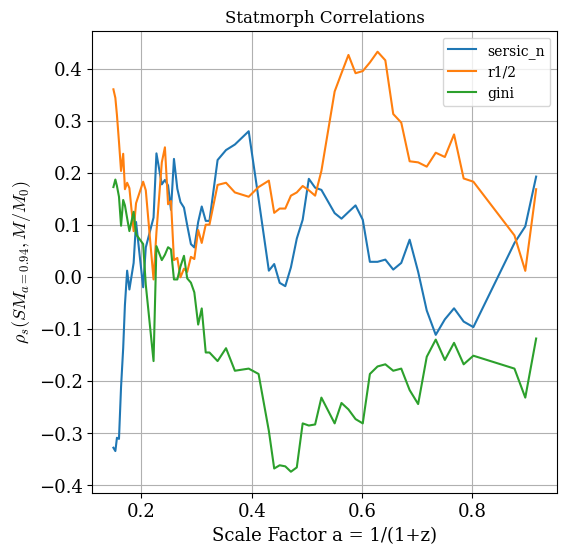

In [108]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
axs.set_title('Statmorph Correlations')
axs.plot(aexp, sersic_n, label='sersic_n')
axs.plot(aexp, rhalf_ellip, label='r1/2')
axs.plot(aexp, gini, label='gini')
axs.set_xlabel('Scale Factor a = 1/(1+z)')
axs.set_ylabel(r'$\rho_s (SM_{a=0.94}, M/M_0)$')
axs.grid()
plt.legend()
plt.show()

## SM + DS

In [98]:
# using new ICs
ds_df = pd.read_csv('data/gadgetx3k_20/snap_125_18.dyn', header=1, sep=r'\s+')
ds_df.drop(columns=['region'], inplace=True)
display(ds_df)
display(sm_df)

,fm2500,fm2500_2,delta2500,fm500,fm500_2,delta500,fm200,fm200_2,delta200
0,0.048,0.023,0.039,0.186,0.068,0.081,0.198,0.042,0.082
1,0.141,0.059,0.083,0.093,0.024,0.034,0.099,0.018,0.042
2,0.029,0.003,0.021,0.090,0.023,0.062,0.183,0.077,0.100
3,0.068,0.014,0.067,0.115,0.012,0.052,0.138,0.020,0.055
4,0.050,0.030,0.031,0.112,0.027,0.065,0.097,0.016,0.164
5,0.053,0.027,0.030,0.078,0.009,0.035,0.167,0.051,0.116
6,0.018,0.002,0.043,0.078,0.010,0.044,0.087,0.007,0.024
7,0.168,0.088,0.109,0.166,0.035,0.090,0.163,0.026,0.087
8,0.036,0.007,0.027,0.068,0.006,0.046,0.117,0.036,0.047
9,0.032,0.005,0.046,0.070,0.021,0.061,0.160,0.048,0.119


,xc_centroid,yc_centroid,ellipticity_asymmetry,ellipticity_centroid,elongation_asymmetry,elongation_centroid,orientation_centroid,xc_asymmetry,yc_asymmetry,orientation_asymmetry,...,A,S,sersic_amplitude,sersic_rhalf,sersic_n,sersic_xc,sersic_yc,sersic_ellip,sersic_theta,sersic_chi2_dof
0,980.459076,1009.086135,0.261055,0.228771,1.353280,1.296631,0.039039,1035.272238,1021.738205,0.074907,...,0.784051,0.201703,1.955523e+08,51.570681,1.534739,1028.487234,1023.651955,0.144700,2.753890,1.786794e+07
1,1032.855242,1026.590281,0.132580,0.131388,1.152844,1.151262,0.420309,1024.265243,1025.201405,0.417066,...,1.033357,0.439181,2.255313e+08,60.074684,0.010000,1011.303259,1032.661020,0.228289,0.600356,2.151986e+07
2,1021.928949,972.399705,0.163734,0.210432,1.195791,1.266515,0.339202,1025.182823,1023.384926,0.477074,...,1.084204,0.376178,1.121379e+07,313.753531,4.618695,1024.778003,1023.444709,0.395568,0.265681,1.360963e+06
3,1020.427776,1001.707424,0.170690,0.167367,1.205822,1.201010,-0.194880,1004.716154,998.260262,-0.179902,...,0.937915,0.377431,1.247672e+07,374.741005,4.390477,1024.560327,1022.516890,0.319651,2.722912,5.994524e+04
4,1063.126350,1001.359756,0.322317,0.292954,1.475615,1.414335,-0.423615,1016.245508,1023.776442,-0.426989,...,1.205434,0.570928,1.065058e+05,1355.337875,0.010000,2080.407042,90.529976,0.903098,2.442784,2.405458e+07
5,984.952614,1009.554657,0.416668,0.406474,1.714291,1.684846,0.497910,1022.222408,1023.313242,0.489969,...,1.460696,0.623140,5.282529e+07,112.860053,2.355637,1023.467523,1023.219516,0.564255,0.494363,1.460267e+07
6,1018.725126,1040.744096,0.144641,0.147359,1.169100,1.172826,-0.368482,1023.254079,1023.655487,-0.389720,...,1.103029,0.539551,4.661364e+07,127.890433,0.010000,1016.237634,1036.139897,0.410434,2.563477,1.704858e+07
7,974.360462,1016.434909,0.222872,0.240702,1.286790,1.317006,0.912928,1026.290215,1016.701466,0.808052,...,1.451672,0.439001,1.097330e+06,1449.824543,5.888010,1025.446247,1022.579044,0.176720,2.462430,5.742438e+04
8,1043.093996,1017.536179,0.134933,0.135138,1.155980,1.156253,-1.032352,1023.452649,1023.414955,-1.003692,...,1.023069,0.524983,9.556824e+09,4.270989,0.720385,1023.458127,1023.417119,0.019542,1.769511,3.369235e+04
9,963.809984,1019.870706,0.315048,0.316686,1.459956,1.463456,-0.599834,1023.479608,1023.478233,-0.514601,...,1.238269,0.007893,7.544691e+08,16.218824,2.891136,1023.342341,1023.509178,0.215603,1.625535,1.717577e+07


In [99]:
df = pd.concat([ds_df, sm_df], axis=1)
df

,fm2500,fm2500_2,delta2500,fm500,fm500_2,delta500,fm200,fm200_2,delta200,xc_centroid,...,A,S,sersic_amplitude,sersic_rhalf,sersic_n,sersic_xc,sersic_yc,sersic_ellip,sersic_theta,sersic_chi2_dof
0,0.048,0.023,0.039,0.186,0.068,0.081,0.198,0.042,0.082,980.459076,...,0.784051,0.201703,1.955523e+08,51.570681,1.534739,1028.487234,1023.651955,0.144700,2.753890,1.786794e+07
1,0.141,0.059,0.083,0.093,0.024,0.034,0.099,0.018,0.042,1032.855242,...,1.033357,0.439181,2.255313e+08,60.074684,0.010000,1011.303259,1032.661020,0.228289,0.600356,2.151986e+07
2,0.029,0.003,0.021,0.090,0.023,0.062,0.183,0.077,0.100,1021.928949,...,1.084204,0.376178,1.121379e+07,313.753531,4.618695,1024.778003,1023.444709,0.395568,0.265681,1.360963e+06
3,0.068,0.014,0.067,0.115,0.012,0.052,0.138,0.020,0.055,1020.427776,...,0.937915,0.377431,1.247672e+07,374.741005,4.390477,1024.560327,1022.516890,0.319651,2.722912,5.994524e+04
4,0.050,0.030,0.031,0.112,0.027,0.065,0.097,0.016,0.164,1063.126350,...,1.205434,0.570928,1.065058e+05,1355.337875,0.010000,2080.407042,90.529976,0.903098,2.442784,2.405458e+07
5,0.053,0.027,0.030,0.078,0.009,0.035,0.167,0.051,0.116,984.952614,...,1.460696,0.623140,5.282529e+07,112.860053,2.355637,1023.467523,1023.219516,0.564255,0.494363,1.460267e+07
6,0.018,0.002,0.043,0.078,0.010,0.044,0.087,0.007,0.024,1018.725126,...,1.103029,0.539551,4.661364e+07,127.890433,0.010000,1016.237634,1036.139897,0.410434,2.563477,1.704858e+07
7,0.168,0.088,0.109,0.166,0.035,0.090,0.163,0.026,0.087,974.360462,...,1.451672,0.439001,1.097330e+06,1449.824543,5.888010,1025.446247,1022.579044,0.176720,2.462430,5.742438e+04
8,0.036,0.007,0.027,0.068,0.006,0.046,0.117,0.036,0.047,1043.093996,...,1.023069,0.524983,9.556824e+09,4.270989,0.720385,1023.458127,1023.417119,0.019542,1.769511,3.369235e+04
9,0.032,0.005,0.046,0.070,0.021,0.061,0.160,0.048,0.119,963.809984,...,1.238269,0.007893,7.544691e+08,16.218824,2.891136,1023.342341,1023.509178,0.215603,1.625535,1.717577e+07


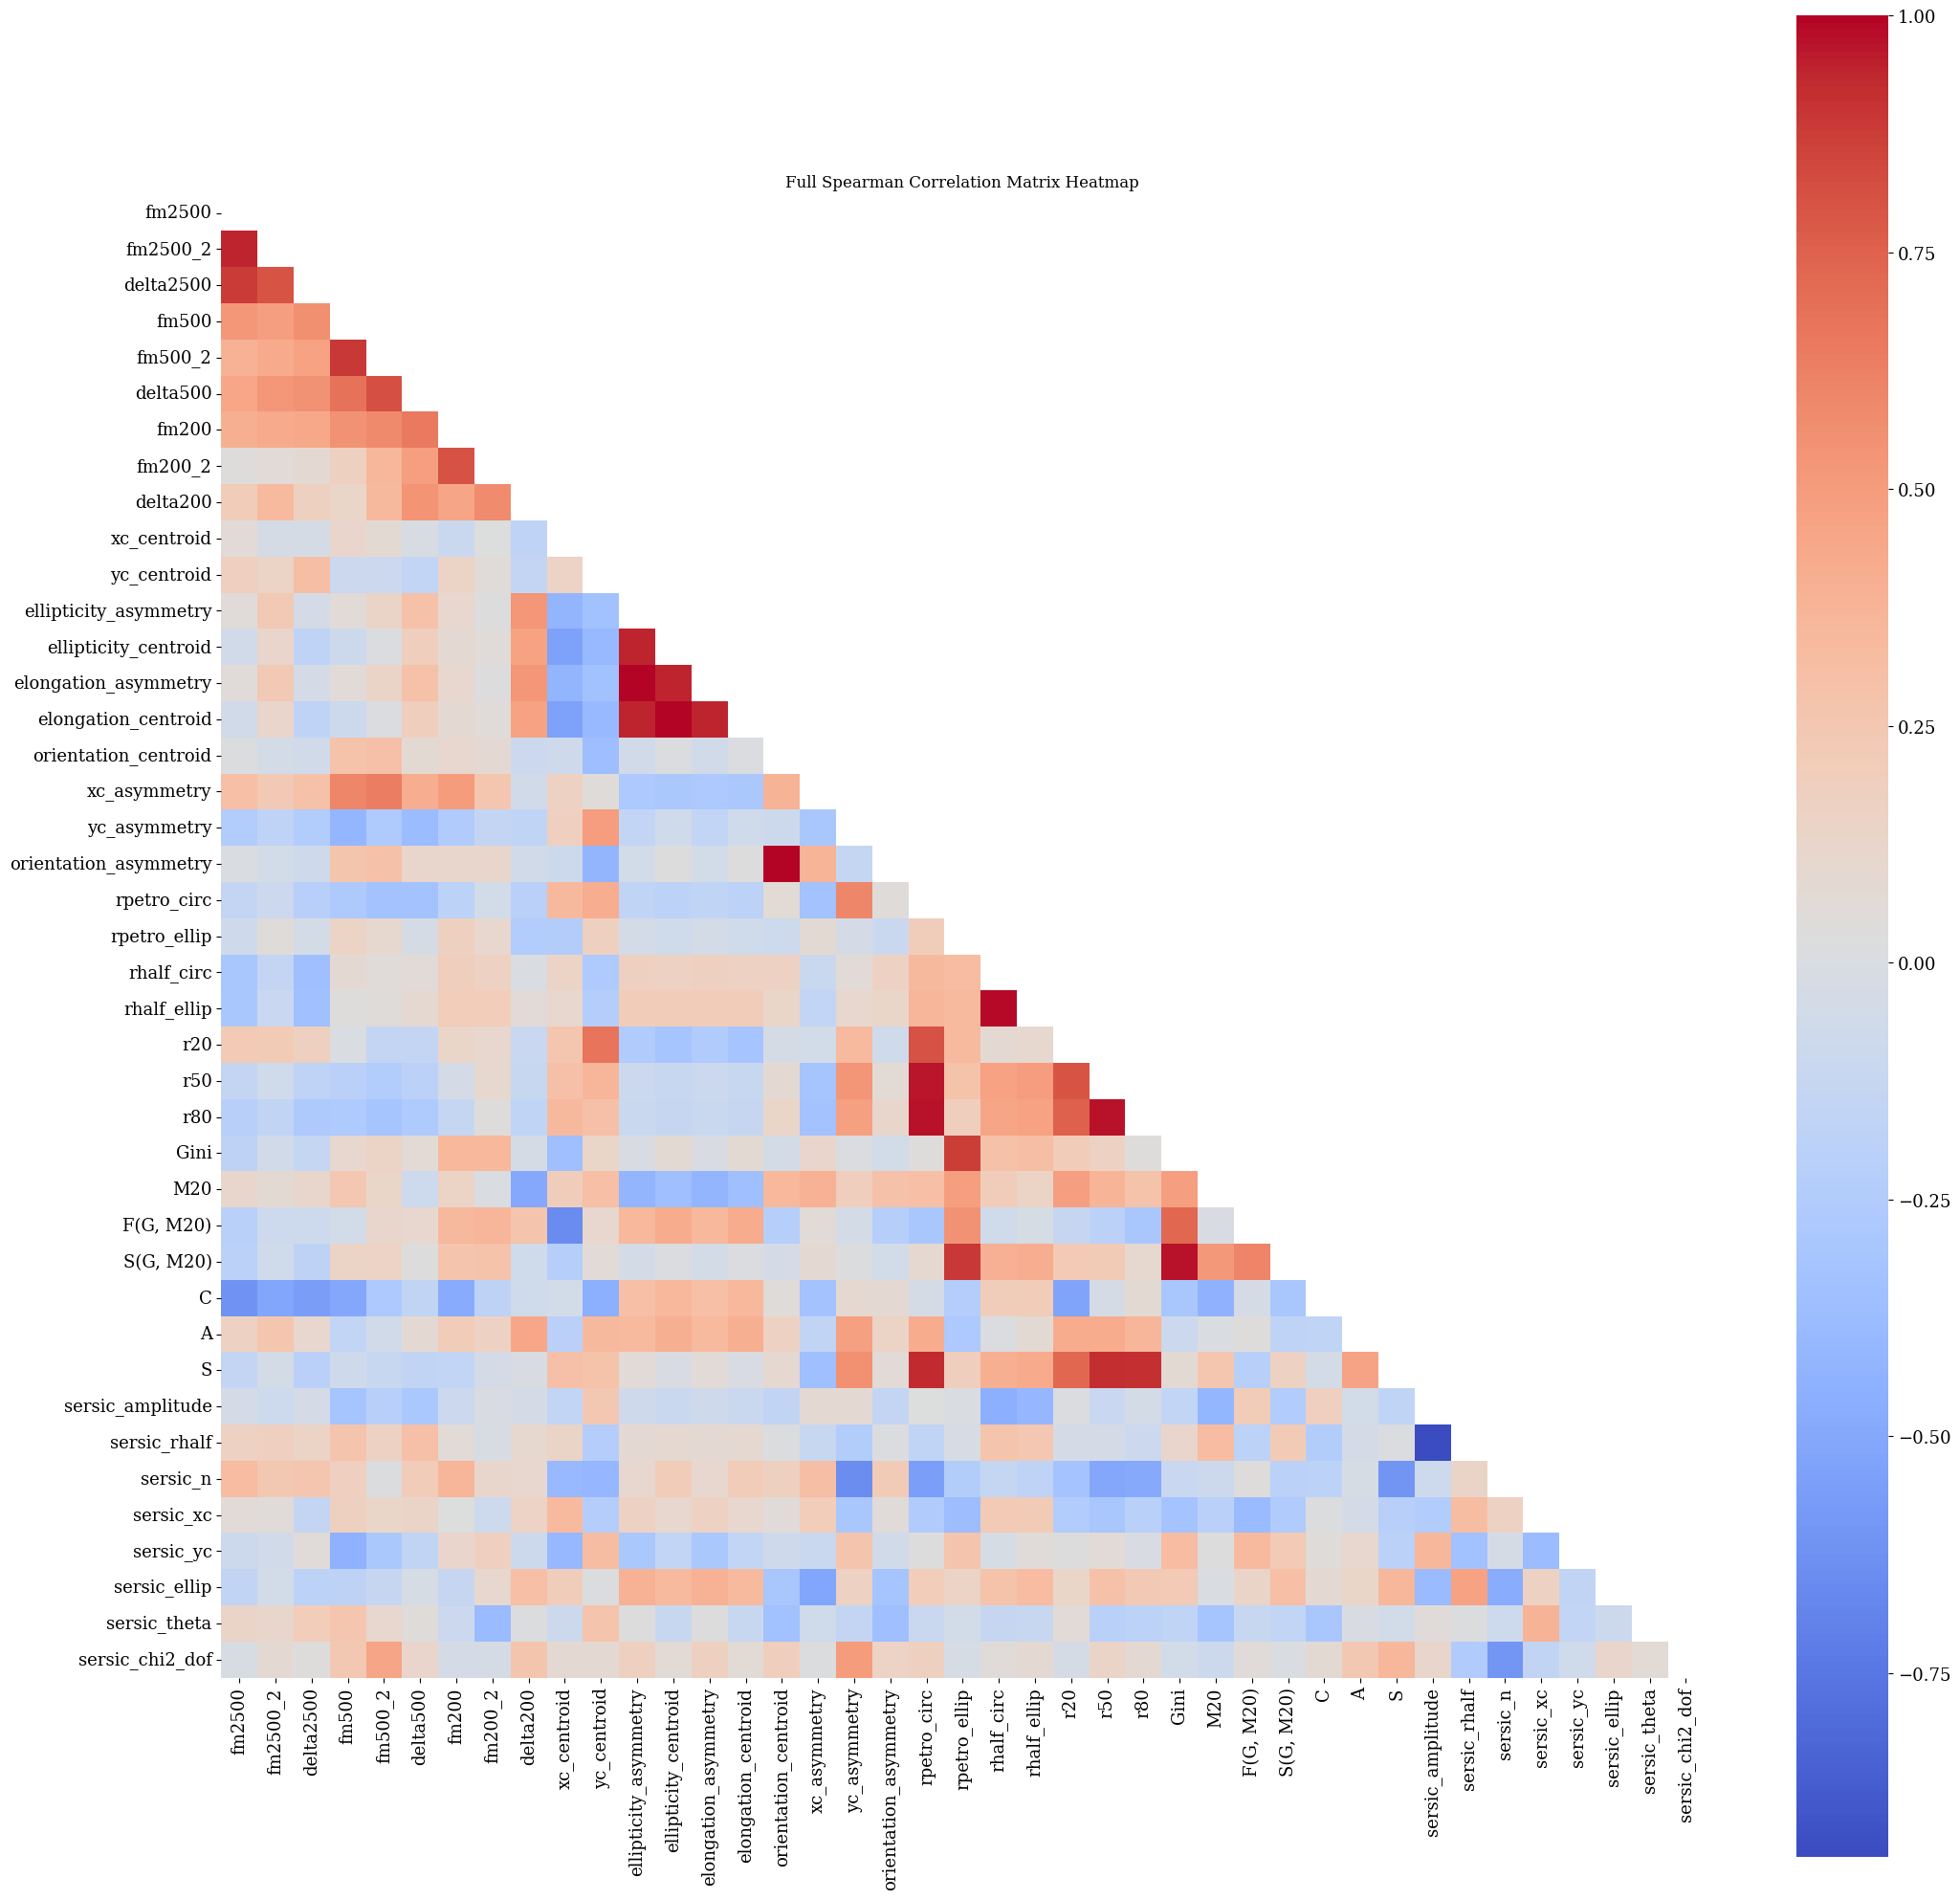

In [100]:
corrs = df.corr(method='spearman')
plots.plot_corr_matrix(corrs)

In [ ]:
# using old ICs

rds_today = 'data/gadgetx3k_20/G3X_progenitors/DS_G3X_snap_125_center-cluster_progenitors.txt'
rds_today = pd.read_csv(rds_today, sep=r'\s+')
rds_today.drop(columns=['rID[0]', 'Hid[1]', 'DS_200[2]', 'DS_500[7]'], 
               inplace=True)
rds_today = rds_today[:20]


In [ ]:
ds_df = rds_today.drop(labels=[14, 15], axis=0)
df = pd.concat([ds_df, sm_df], axis=1)
corrs = df.corr(method='spearman')
plots.plot_corr_matrix(corrs)

Now doing same as above but with annular mask...

In [36]:
image = fits.open('data/gadgetx3k_20/maps/bcg_0001_125_0.fits')
image = image[0].data
center = (int(len(image[1])//2), int(len(image[0])//2))
segmap = utils.data.annular_mask(image, center, r1 = 20, r2=1024)

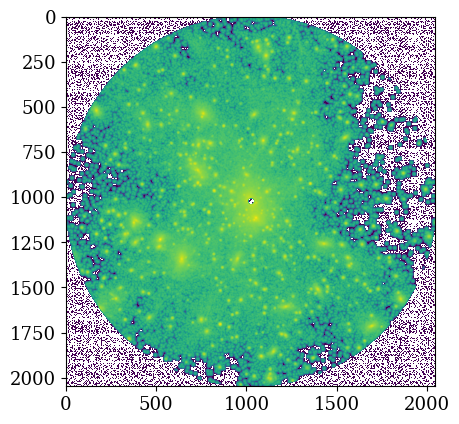

In [37]:
fig, axs = plt.subplots(1, 1)
plots.display_img(image, axs, mask=segmap)
plt.show()

In [51]:
import astropy.units as u

In [70]:
diameter = 5*u.Mpc
diameter.to(u.kpc).value + 50

np.float64(5050.0)

In [ ]:
def real2pix(r, map=None, scale=5*u.Mpc):
    scale = scale.to(u.kpc)
    pixperkpc = 2048/scale.value
    radius = r.value*pixperkpc
    return int(radius)

In [86]:
real2pix(1000*u.kpc)

0.4096


409

Processing region 1...


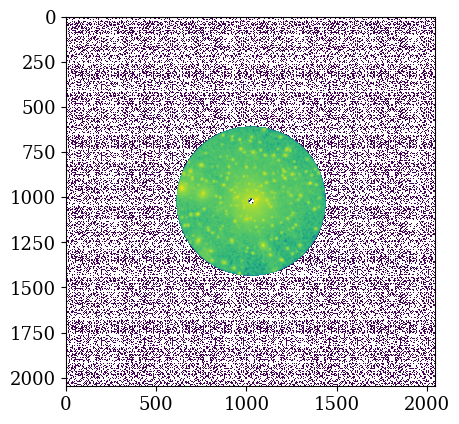

-------region 1 done-------
Processing region 2...


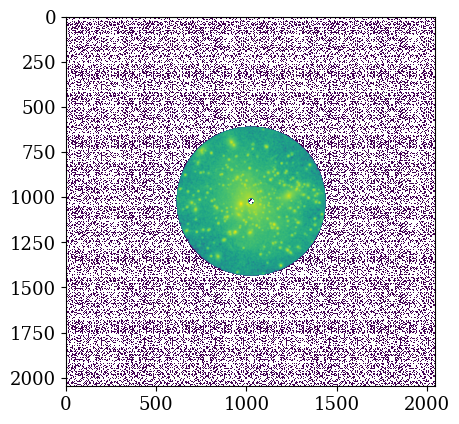

-------region 2 done-------
Processing region 3...


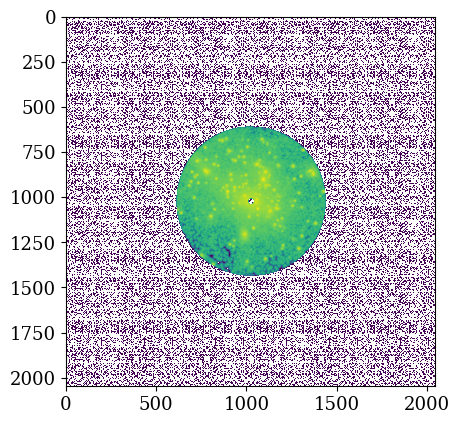

-------region 3 done-------
Processing region 4...


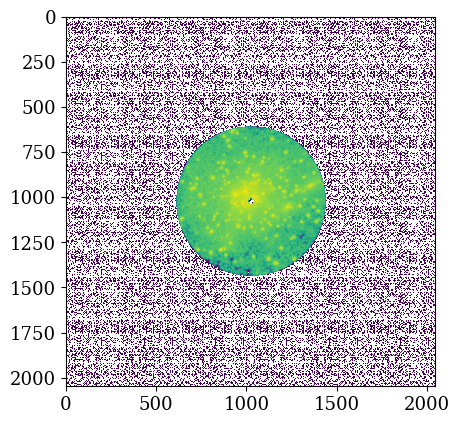

-------region 4 done-------
Processing region 5...


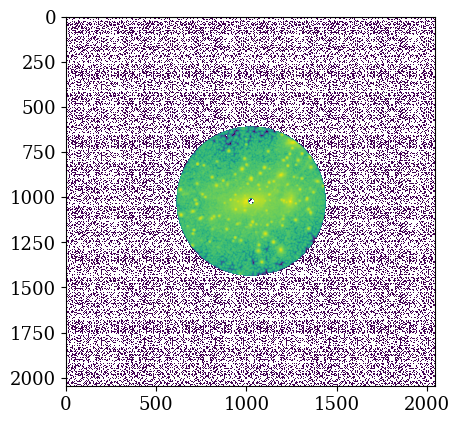

-------region 5 done-------
Processing region 6...


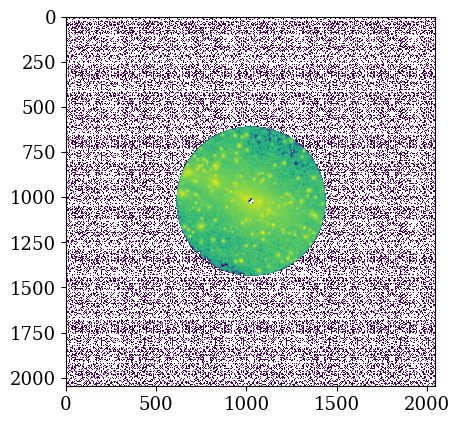

-------region 6 done-------
Processing region 7...


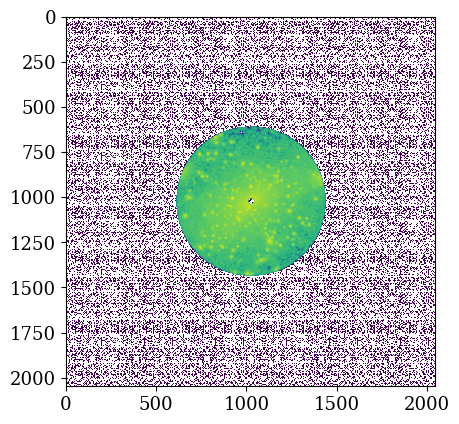

-------region 7 done-------
Processing region 8...


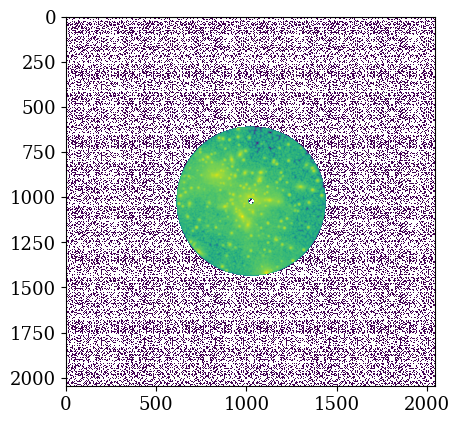

-------region 8 done-------
Processing region 9...


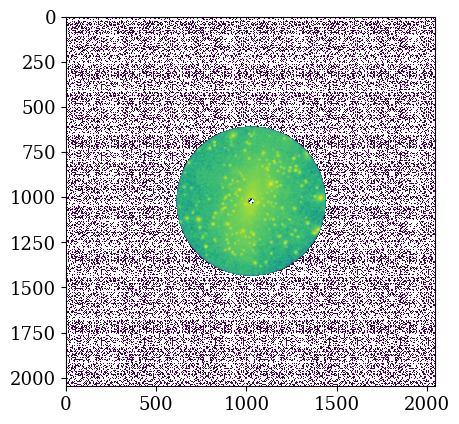

-------region 9 done-------
Processing region 10...


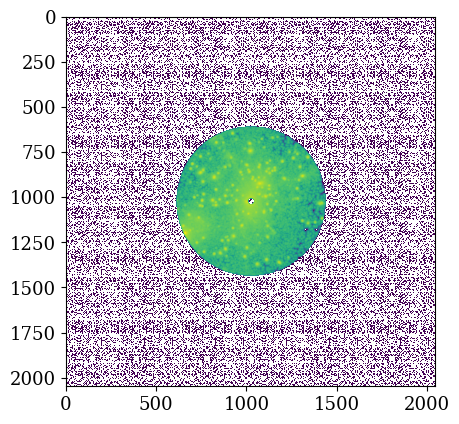

-------region 10 done-------
Processing region 11...


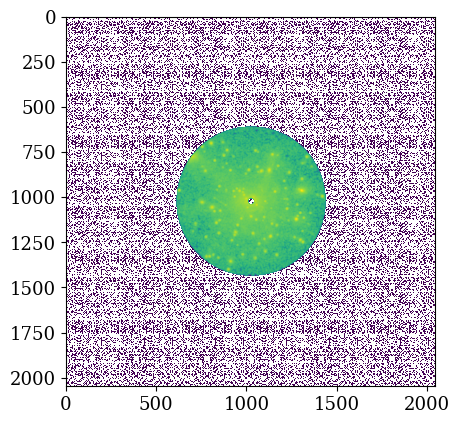

-------region 11 done-------
Processing region 12...


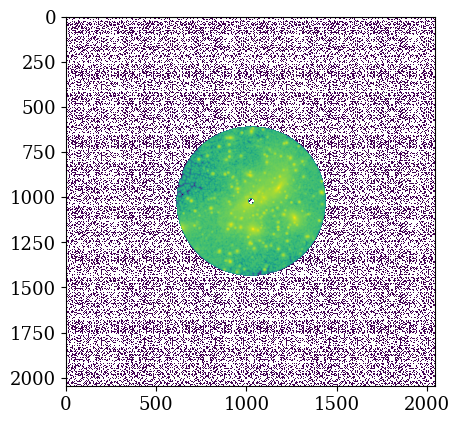

-------region 12 done-------
Processing region 15...


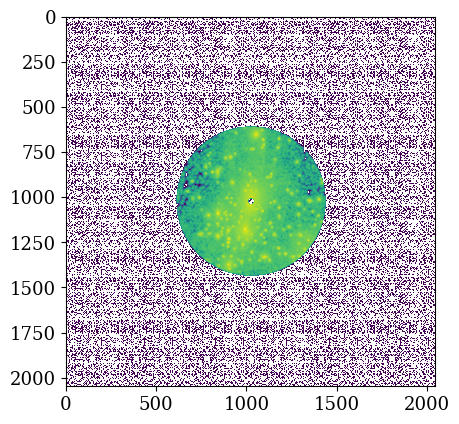

-------region 15 done-------
Processing region 16...


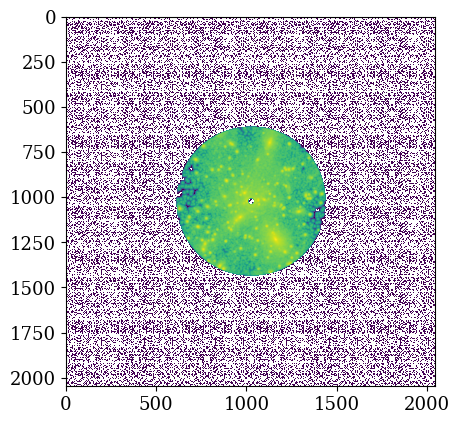

-------region 16 done-------
Processing region 17...


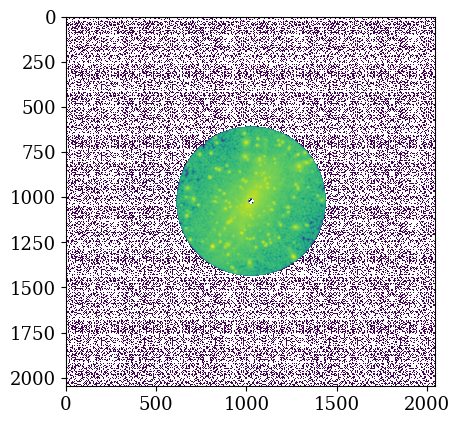

-------region 17 done-------
Processing region 18...


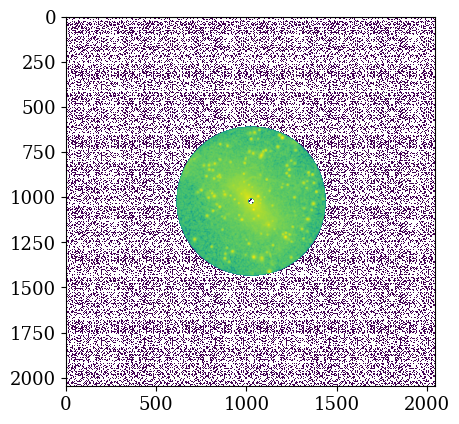

-------region 18 done-------
Processing region 19...


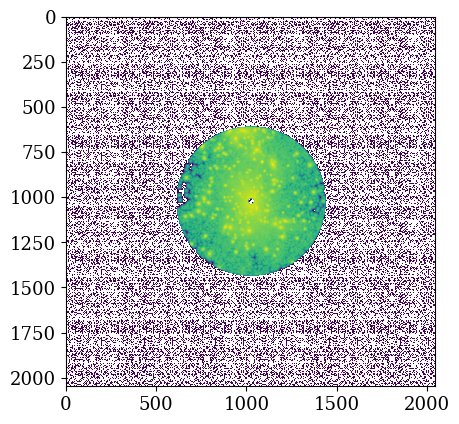

-------region 19 done-------
Processing region 20...


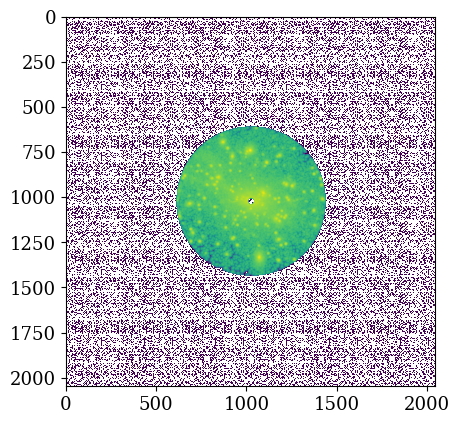

-------region 20 done-------


In [89]:
morphs_list = []
for id in np.arange(1, 21):
    try:
        file = fits.open(f'data/gadgetx3k_20/maps/bcg_{str(id).zfill(4)}_125_1.fits')
    except FileNotFoundError:
        continue
    print(f"Processing region {id}...")
    image = file[0].data
    center = (int(len(image[1])//2), int(len(image[0])//2))
    # r1 = 50*u.kpc
    # r1 = real2pix(r=r1, map=image)
    # r2 = 1*u.Mpc
    # r2 = real2pix(r=r2, map=image)
    segmap = utils.data.annular_mask(image, center, r1=20, r2=409)

    fig, axs = plt.subplots(1, 1)
    plots.display_img(image, axs, mask=segmap)
    plt.show()
    morph = statmorph.source_morphology(image, segmap, gain=2.25)
    print(f'-------region {id} done-------')
    morphs_list.append(morph[0])

sm_df = utils.data.create_morph_df(morphs_list, 
                                   name='results/rin_50kpc_rout_1Mpc.csv',
                                   save=True)